In [1]:
%matplotlib inline
import matplotlib.pyplot
import numpy
import os
import math
import string
import json
import pandas
import scipy
import scipy.spatial
import scipy.stats
import tqdm
import networkx
import random
import sklearn.linear_model
import psycopg2
import configparser
import sqlalchemy
import seaborn

In [2]:
config = configparser.ConfigParser()
#config.read(args.pgconf)
config.read("db.conf")

['db.conf']

In [3]:
dbname = config['database']['dbname']
user = config['database']['user']
password = config['database']['password']
host = config['database']['host']
port = config['database']['port']
conn = psycopg2.connect(f'dbname={dbname} user={user} password={password} host={host} port={port}')
read_cursor = conn.cursor()
write_cursor = conn.cursor()
engine = sqlalchemy.create_engine(
    f"postgresql+psycopg2://{user}:{password}@{host}:5432/{dbname}")

In [4]:
language_families = pandas.read_sql("select * from language_family order by iso_639_3_code", engine)
language_family_columns = [x for x in language_families.columns if x not in ['entity', 'language_name', 'iso_639_3_code']]
language_families

,entity,language_name,iso_639_3_code,niger_congo,austronesian,trans_new_guinea,sino_tibetan,indo_european,australian_aboriginal,afro_asiatic,nilo_saharan,oto_manguean,austroasiatic,kra_dai,dravidian,tupian,atlantic_congo,pama_nyungan,arawakan,mande
0,Q4790560,Arifama-Miniafia,aai,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,Q3446690,Ankave,aak,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,Q3073568,Abau,aau,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,Q4740192,Amarasi,aaz,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,Q34835,Abua,abn,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1605,Q3574818,Quioquitani Zapotec,ztq,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
1606,Q3574815,Yatee Zapotec,zty,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
1607,Q10179,Zulu,zul,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
1608,Q8054983,Yongbei Zhuang,zyb,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [5]:
language_family_columns

['niger_congo',
 'austronesian',
 'trans_new_guinea',
 'sino_tibetan',
 'indo_european',
 'australian_aboriginal',
 'afro_asiatic',
 'nilo_saharan',
 'oto_manguean',
 'austroasiatic',
 'kra_dai',
 'dravidian',
 'tupian',
 'atlantic_congo',
 'pama_nyungan',
 'arawakan',
 'mande']

In [6]:
melted = pandas.read_sql("select * from machine_learning_morphology_best_scores", engine)
melted

,mlm_score_id,language,bible_version_id,calculation_algorithm,algorithm_region_size_parameter,result_version,answers_correct,answers_wrong,total_vocab_size_checked,when_added,computation_time,computation_hostname,proportion_correct,rank_within_language_and_algorithm_and_region_size,rank_within_language_and_algorithm,rank_within_version_and_algorithm_and_region_size,rank_within_version_and_algorithm
0,538584,eng,1,GlobalPadicLinear,NaN,0.03,48,53,101,2022-02-21,2478.573842,msi-linux,0.475248,4,4,1,1
1,538711,eng,1,GlobalSiegel,NaN,0.03,48,53,101,2022-02-23,13.105294,msi-linux,0.475248,4,4,1,1
2,556151,eng,1,HybridSiegel,20.0,0.03,57,72,129,2022-02-26,0.239557,msi-linux,0.441860,4,9,1,1
3,556150,eng,1,HybridSiegel,19.0,0.03,56,73,129,2022-02-26,0.217616,msi-linux,0.434109,4,15,1,2
4,556149,eng,1,HybridSiegel,18.0,0.03,54,75,129,2022-02-26,0.199507,msi-linux,0.418605,4,18,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119407,559643,kor,2357,LocalPadicLinear,7.0,0.03,4,73,77,2022-02-26,0.236154,msi-linux,0.051948,1,15,1,15
119408,559637,kor,2357,LocalPadicLinear,4.0,0.03,2,75,77,2022-02-26,0.070112,msi-linux,0.025974,1,16,1,16
119409,559639,kor,2357,LocalPadicLinear,5.0,0.03,2,75,77,2022-02-26,0.102354,msi-linux,0.025974,1,17,1,17
119410,559635,kor,2357,LocalPadicLinear,3.0,0.03,1,76,77,2022-02-26,0.027884,msi-linux,0.012987,1,18,1,18


In [7]:
by_language = pandas.read_sql("""
select * 
  from machine_learning_morphology_summary_by_language 
  left join language_family 
  on (machine_learning_morphology_summary_by_language.language = language_family.iso_639_3_code)""", engine)
by_language['all_human'] = True
by_language

,language,global_padic_bible_version_id,global_padic_linear_proportion_correct,global_siegel_bible_version_id,global_siegel_proportion_correct,hybrid_siegel_bible_version_id,hybrid_siegel_best_region_size,hybrid_siegel_proportion_correct,local_euclidean_bible_version_id,local_euclidean_siegel_best_region_size,...,oto_manguean,austroasiatic,kra_dai,dravidian,tupian,atlantic_congo,pama_nyungan,arawakan,mande,all_human
0,ace,69,0.134021,69,0.000000,69,11,0.072165,69,11,...,False,False,False,False,False,False,False,False,False,True
1,ady,84,0.000000,84,0.000000,84,3,0.000000,84,3,...,False,False,False,False,False,False,False,False,False,True
2,alt,2143,0.027397,2143,0.000000,2143,4,0.013699,2143,3,...,False,False,False,False,False,False,False,False,False,True
3,ary,2213,0.000000,2213,0.000000,2213,3,0.000000,2213,3,...,False,False,False,False,False,False,False,False,False,True
4,atj,168,0.223684,168,0.000000,168,10,0.171053,168,16,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1492,daf,434,0.233577,434,0.000000,434,7,0.109489,434,20,...,None,None,None,None,None,None,None,None,None,True
1493,bcc_rom,218,0.197368,218,0.000000,218,15,0.065789,218,9,...,None,None,None,None,None,None,None,None,None,True
1494,por_pt,1533,0.592593,1533,0.592593,1533,15,0.592593,1533,14,...,None,None,None,None,None,None,None,None,None,True
1495,tuk_arb,2229,0.127273,2229,0.000000,2229,3,0.000000,2229,12,...,None,None,None,None,None,None,None,None,None,True


In [8]:
languages_with_no_recorded_family = list(by_language[by_language.indo_european.isnull()].language)
languages_with_no_recorded_family

['rmy_ch',
 'hak_rom',
 'hin_ro',
 'mya_zaw',
 'urd_rom',
 'uig_cyr',
 'rmy_fr',
 'lif_dev',
 'fuv_ar',
 'urd_dv',
 'syl_nag',
 'esi',
 'fub_ar',
 'ike_lab',
 'spa_es',
 'kde_mz',
 'sus_ar',
 'shu_rom',
 'daf',
 'bcc_rom',
 'por_pt',
 'tuk_arb',
 'rmn_arl']

In [9]:
by_language.fillna(False, inplace=True)

In [10]:
languages_not_elsewhere_classified = list(by_language[~by_language[language_family_columns].any(axis=1)].language)
languages_not_elsewhere_classified

['ady',
 'alt',
 'atj',
 'azb',
 'bxr',
 'chr',
 'gag',
 'jam',
 'kaa',
 'kbd',
 'krc',
 'lez',
 'pap',
 'sah',
 'srn',
 'tyv',
 'xal',
 'coe',
 'cpu',
 'soq',
 'tuk',
 'nbc',
 'ain',
 'chv',
 'crh',
 'gul',
 'ikt',
 'ken',
 'khk',
 'kjh',
 'kmu',
 'kyq',
 'mam',
 'nii',
 'poh',
 'pri',
 'quc',
 'quy',
 'tab',
 'tgo',
 'akh',
 'arn',
 'bkq',
 'gam',
 'mbt',
 'xla',
 'zyb',
 'lcm',
 'kat',
 'amm',
 'boa',
 'awb',
 'noa',
 'pad',
 'tur',
 'sny',
 'amr',
 'cbu',
 'mcq',
 'icr',
 'ind',
 'cul',
 'cao',
 'rkb',
 'kwk',
 'apy',
 'gum',
 'kvg',
 'mta',
 'acf',
 'dad',
 'mbs',
 'quh',
 'nas',
 'ksp',
 'hub',
 'top',
 'mca',
 'nmh',
 'cam',
 'crt',
 'sja',
 'yaa',
 'txu',
 'cpa',
 'nhg',
 'aey',
 'mfh',
 'txt',
 'cmr',
 'cle',
 'dak',
 'caf',
 'cbs',
 'dgz',
 'cbr',
 'hun',
 'juy',
 'maa',
 'mdm',
 'mti',
 'mbc',
 'mhl',
 'mpx',
 'ojb',
 'atg',
 'atd',
 'czt',
 'too',
 'yat',
 'cof',
 'geb',
 'saw',
 'kxw',
 'crl',
 'kyu',
 'qvn',
 'yut',
 'srm',
 'tac',
 'cek',
 'iws',
 'cbt',
 'gug',
 'cac',


In [11]:
by_language['unrecorded'] = by_language.language.isin(languages_with_no_recorded_family)
by_language['unclassified'] = by_language.language.isin(languages_not_elsewhere_classified)

In [12]:
by_version = pandas.read_sql("""
select * 
  from machine_learning_morphology_summary_by_version 
  left join language_family 
  on (machine_learning_morphology_summary_by_version.language = language_family.iso_639_3_code)""", engine)
by_version['all_human'] = True
by_version['unrecorded'] = by_version.language.isin(languages_with_no_recorded_family)
by_version['unclassified'] = by_version.language.isin(languages_not_elsewhere_classified)
by_version.fillna(False, inplace=True)
by_version

,language,bible_version_id,global_padic_linear_proportion_correct,global_siegel_proportion_correct,hybrid_siegel_best_region_size,hybrid_siegel_proportion_correct,local_euclidean_siegel_best_region_size,local_euclidean_siegel_proportion_correct,local_padic_linear_best_region_size,local_padic_linear_proportion_correct,...,kra_dai,dravidian,tupian,atlantic_congo,pama_nyungan,arawakan,mande,all_human,unrecorded,unclassified
0,ace,69,0.134021,0.0,11,0.072165,11,0.030928,18,0.092784,...,False,False,False,False,False,False,False,True,False,False
1,ady,84,0.000000,0.0,3,0.000000,3,0.000000,3,0.000000,...,False,False,False,False,False,False,False,True,False,True
2,alt,2143,0.027397,0.0,4,0.013699,3,0.000000,10,0.041096,...,False,False,False,False,False,False,False,True,False,True
3,ary,2213,0.000000,0.0,3,0.000000,3,0.000000,3,0.000000,...,False,False,False,False,False,False,False,True,False,False
4,atj,168,0.223684,0.0,10,0.171053,16,0.184211,8,0.171053,...,False,False,False,False,False,False,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2087,fub_ar,2237,0.000000,0.0,3,0.000000,3,0.000000,8,0.025641,...,False,False,False,False,False,False,False,True,True,True
2088,ike_lab,788,0.000000,0.0,3,0.000000,3,0.000000,3,0.000000,...,False,False,False,False,False,False,False,True,True,True
2089,shu_rom,149,0.102564,0.0,3,0.000000,18,0.025641,16,0.012821,...,False,False,False,False,False,False,False,True,True,True
2090,daf,434,0.233577,0.0,7,0.109489,20,0.094891,15,0.124088,...,False,False,False,False,False,False,False,True,True,True


In [13]:
extra_families = ['all_human', 'unrecorded', 'unclassified']

In [14]:
proportion_correct_columns = [x for x in by_version.columns if x.endswith('proportion_correct')]
proportion_correct_columns

['global_padic_linear_proportion_correct',
 'global_siegel_proportion_correct',
 'hybrid_siegel_proportion_correct',
 'local_euclidean_siegel_proportion_correct',
 'local_padic_linear_proportion_correct',
 'y_equals_x_proportion_correct']

In [15]:
by_language[proportion_correct_columns].describe()

,global_padic_linear_proportion_correct,global_siegel_proportion_correct,hybrid_siegel_proportion_correct,local_euclidean_siegel_proportion_correct,local_padic_linear_proportion_correct,y_equals_x_proportion_correct
count,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000
mean,0.120988,0.016428,0.066770,0.085028,0.108755,0.133228
std,0.127187,0.074784,0.074573,0.084896,0.093834,0.078643
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.008197
25%,0.000000,0.000000,0.016393,0.025316,0.038462,0.073684
50%,0.090909,0.000000,0.043478,0.059701,0.086957,0.116071
75%,0.223684,0.000000,0.095238,0.120000,0.153846,0.176991
max,0.592593,0.592593,0.670103,0.592593,0.670103,0.523256


In [16]:
average_correct_by_language_family = pandas.DataFrame({ x: 
by_language[by_language[x]][proportion_correct_columns].mean()
for x in (language_family_columns + extra_families)
}).T
average_correct_by_language_family

,global_padic_linear_proportion_correct,global_siegel_proportion_correct,hybrid_siegel_proportion_correct,local_euclidean_siegel_proportion_correct,local_padic_linear_proportion_correct,y_equals_x_proportion_correct
niger_congo,0.092800,0.005365,0.033090,0.047909,0.077420,0.103093
austronesian,0.202954,0.038011,0.102980,0.142060,0.171602,0.192270
trans_new_guinea,0.123641,0.011181,0.063464,0.083835,0.092404,0.119804
sino_tibetan,0.174434,0.027466,0.087261,0.112410,0.130270,0.154956
indo_european,0.104952,0.056304,0.135068,0.108919,0.154492,0.127169
australian_aboriginal,0.032512,0.000000,0.027231,0.030253,0.037598,0.057598
afro_asiatic,0.039066,0.000356,0.036543,0.039675,0.050896,0.106851
nilo_saharan,0.075643,0.000333,0.038941,0.053697,0.077744,0.120199
oto_manguean,0.144905,0.003271,0.069679,0.112364,0.125039,0.170800
austroasiatic,0.294333,0.085935,0.151099,0.226798,0.244417,0.306033


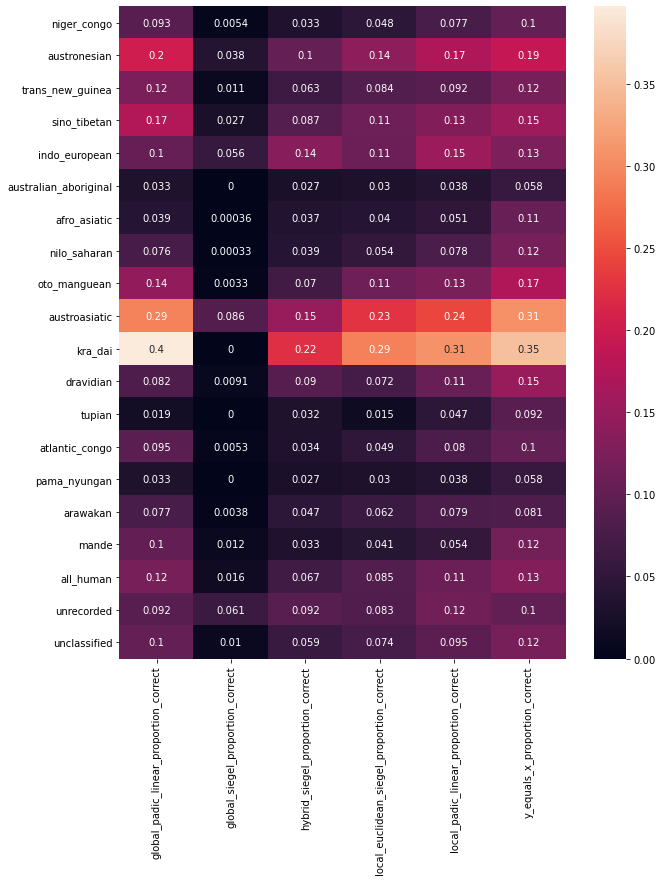

In [17]:
fig, ax = matplotlib.pyplot.subplots(figsize=(10,12))
seaborn.heatmap(average_correct_by_language_family, ax=ax, annot=True)
fig.savefig("heatmap-of-proportion-correct.png")

In [18]:
winning_method_by_family = average_correct_by_language_family.idxmax(axis=1)
winning_method_by_family

niger_congo                       y_equals_x_proportion_correct
austronesian             global_padic_linear_proportion_correct
trans_new_guinea         global_padic_linear_proportion_correct
sino_tibetan             global_padic_linear_proportion_correct
indo_european             local_padic_linear_proportion_correct
australian_aboriginal             y_equals_x_proportion_correct
afro_asiatic                      y_equals_x_proportion_correct
nilo_saharan                      y_equals_x_proportion_correct
oto_manguean                      y_equals_x_proportion_correct
austroasiatic                     y_equals_x_proportion_correct
kra_dai                  global_padic_linear_proportion_correct
dravidian                         y_equals_x_proportion_correct
tupian                            y_equals_x_proportion_correct
atlantic_congo                    y_equals_x_proportion_correct
pama_nyungan                      y_equals_x_proportion_correct
arawakan                          y_equa

niger_congo                       y_equals_x_proportion_correct
austronesian             global_padic_linear_proportion_correct
trans_new_guinea         global_padic_linear_proportion_correct
sino_tibetan             global_padic_linear_proportion_correct
indo_european             local_padic_linear_proportion_correct
australian_aboriginal             y_equals_x_proportion_correct
afro_asiatic                      y_equals_x_proportion_correct
nilo_saharan                      y_equals_x_proportion_correct
oto_manguean                      y_equals_x_proportion_correct
austroasiatic                     y_equals_x_proportion_correct
kra_dai                  global_padic_linear_proportion_correct
dravidian                         y_equals_x_proportion_correct
tupian                            y_equals_x_proportion_correct
atlantic_congo                    y_equals_x_proportion_correct
pama_nyungan                      y_equals_x_proportion_correct
arawakan                          y_equa

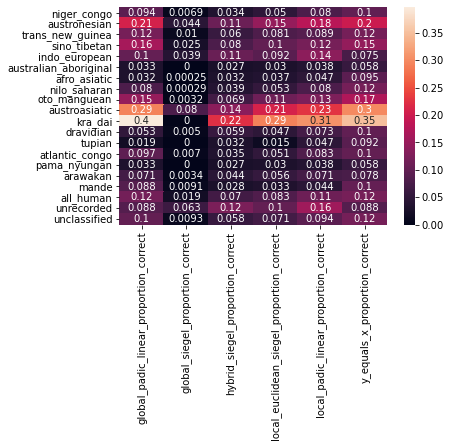

In [19]:
average_correct_by_version = pandas.DataFrame({ x: 
by_version[by_version[x]][proportion_correct_columns].mean()
for x in (language_family_columns + extra_families)
}).T
winning_method_by_version = average_correct_by_version.idxmax(axis=1)
fig, ax = matplotlib.pyplot.subplots(
    #figsize=(10,12)
)
seaborn.heatmap(average_correct_by_version, ax=ax, annot=True)
winning_method_by_version

In [20]:
comparison_pairs = [('y_equals_x_proportion_correct', 'global_padic_linear_proportion_correct'),
                    ('y_equals_x_proportion_correct', 'local_padic_linear_proportion_correct'),
                    ('global_padic_linear_proportion_correct', 'global_siegel_proportion_correct'),
                    ('local_padic_linear_proportion_correct', 'local_euclidean_siegel_proportion_correct')
                   ]

In [33]:
language_p_values = []
for family in language_family_columns + extra_families:
    record = {'family': family }
    for comparison in comparison_pairs:
        l,r = comparison
        l_name = " ".join(l.split('_')[:-2])
        r_name = " ".join(r.split('_')[:-2])
        subset = by_language[by_language[family]]
        p = scipy.stats.mannwhitneyu(subset[l], subset[r]).pvalue
        record[(l_name, r_name)] = p
    language_p_values.append(record)
language_p_values = pandas.DataFrame.from_records(language_p_values).set_index('family')
language_p_values

,"(y equals x, global padic linear)","(y equals x, local padic linear)","(global padic linear, global siegel)","(local padic linear, local euclidean siegel)"
family,,,,
niger_congo,1.276155e-03,7.501476e-10,9.629432e-59,3.781382e-08
austronesian,3.667162e-03,4.966879e-04,7.614916e-32,1.953857e-04
trans_new_guinea,2.853033e-01,2.612024e-04,4.855458e-10,2.565518e-01
sino_tibetan,1.460859e-01,1.483303e-02,3.760518e-14,1.226314e-01
indo_european,3.472875e-04,2.545141e-01,2.251381e-05,1.404375e-03
australian_aboriginal,1.353275e-02,1.464553e-01,8.545176e-02,2.765637e-01
afro_asiatic,2.171568e-07,3.061039e-05,1.477851e-03,2.914001e-01
nilo_saharan,8.289773e-04,1.640395e-03,2.961616e-06,3.099220e-02
oto_manguean,3.686618e-01,1.679325e-05,6.462400e-14,1.673899e-01


<AxesSubplot:ylabel='family'>

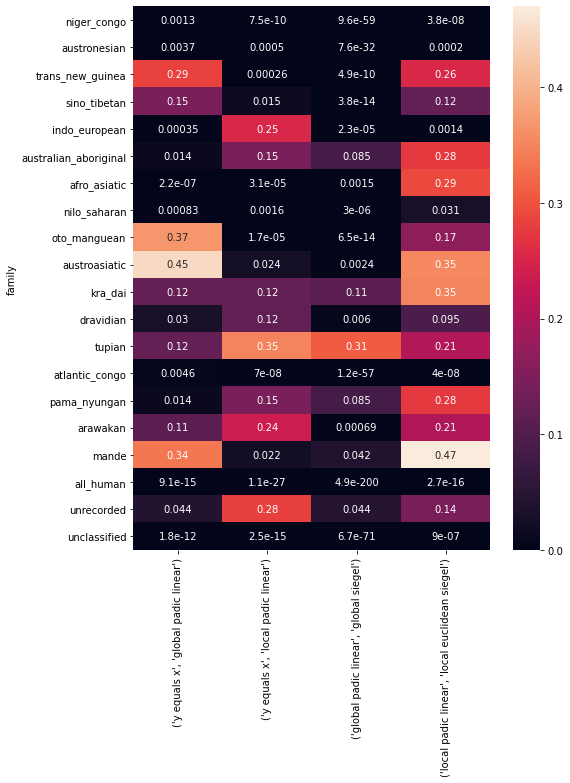

In [35]:
fig, ax = matplotlib.pyplot.subplots(figsize=(8,10))
seaborn.heatmap(language_p_values, annot=True, ax=ax)

<AxesSubplot:ylabel='family'>

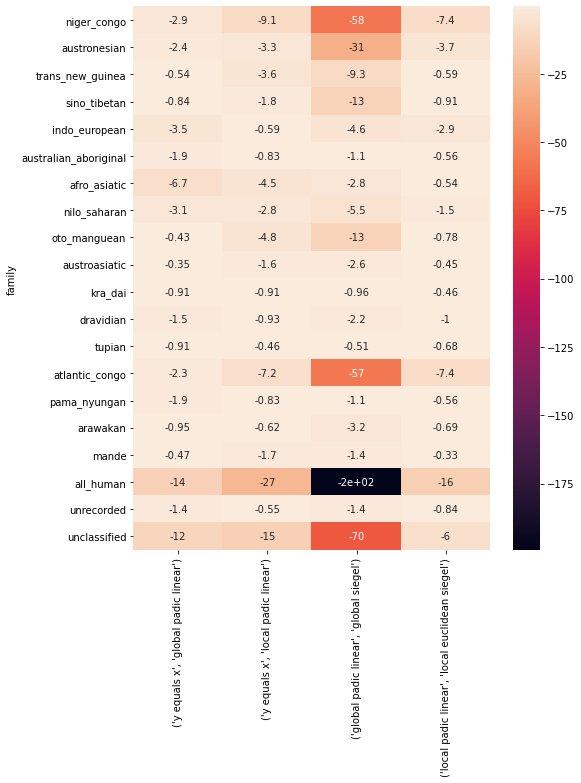

In [38]:
fig, ax = matplotlib.pyplot.subplots(figsize=(8,10))
seaborn.heatmap(language_p_values.applymap(math.log10), annot=True, ax=ax)

In [23]:
melted[melted.proportion_correct == 0]

,mlm_score_id,language,bible_version_id,calculation_algorithm,algorithm_region_size_parameter,result_version,answers_correct,answers_wrong,total_vocab_size_checked,when_added,computation_time,computation_hostname,proportion_correct,rank_within_language_and_algorithm_and_region_size,rank_within_language_and_algorithm,rank_within_version_and_algorithm_and_region_size,rank_within_version_and_algorithm
58,538713,eng,2,GlobalSiegel,NaN,0.03,0,98,98,2022-02-23,13.479995,msi-linux,0.0,21,21,1,1
115,538710,eng,3,GlobalSiegel,NaN,0.03,0,95,95,2022-02-23,12.111096,msi-linux,0.0,22,22,1,1
172,538715,eng,4,GlobalSiegel,NaN,0.03,0,103,103,2022-02-23,16.120422,msi-linux,0.0,23,23,1,1
286,538712,eng,6,GlobalSiegel,NaN,0.03,0,97,97,2022-02-23,13.176423,msi-linux,0.0,24,24,1,1
322,542673,eng,6,LocalEuclideanSiegel,7.0,0.03,0,97,97,2022-02-23,0.111285,msi-linux,0.0,53,965,1,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119353,567642,zho,2336,LocalPadicLinear,20.0,0.03,0,146,146,2022-02-27,174.596929,msi-linux,0.0,6,108,1,18
119355,560696,kor,2357,GlobalPadicLinear,NaN,0.03,0,77,77,2022-02-26,383.130693,msi-linux,0.0,1,1,1,1
119356,554670,kor,2357,GlobalSiegel,NaN,0.03,0,77,77,2022-02-26,3.008068,msi-linux,0.0,1,1,1,1
119391,557327,kor,2357,LocalEuclideanSiegel,3.0,0.03,0,77,77,2022-02-26,0.012332,msi-linux,0.0,1,17,1,17


<AxesSubplot:xlabel='proportion_correct', ylabel='Count'>

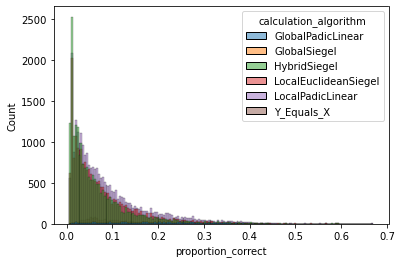

In [24]:
seaborn.histplot(data=melted[melted.proportion_correct > 0], x='proportion_correct', hue='calculation_algorithm')

In [25]:
seaborn.histplot(data=best_approaches[best_approaches.calculation_algorithm == 'GlobalSiegel'], x='proportion_correct', hue='calculation_algorithm')

NameError: name 'best_approaches' is not defined

In [ ]:
seaborn.histplot(data=best_approaches[best_approaches.calculation_algorithm == 'GlobalPadicLinear'], x='proportion_correct', hue='calculation_algorithm')

In [ ]:
fig, ax = matplotlib.pyplot.subplots(figsize=(16,6))
seaborn.histplot(
    data=best_approaches[~best_approaches.calculation_algorithm.str.startswith('Global')], 
    x='proportion_correct', 
    hue='calculation_algorithm',
    kde=True,
    ax=ax
)
#ax.set_title("Distribution of best results for all local algorithms")
ax.set_xlabel("Proportion of nouns that formed a correct plural using each linear algorithm")
ax.set_ylabel("Number of languages where this happened")
fig.tight_layout()
fig.savefig('Images/algo-hist.png')

In [ ]:
wide_form = best_approaches.pivot_table(index='bible_version_id', columns='calculation_algorithm',
                           values='proportion_correct')
wide_form

In [ ]:
wide_form.describe().T

In [ ]:
fig, ax = matplotlib.pyplot.subplots(ncols=2, figsize=(12,4))
euclidean_vs_padic = wide_form.LocalPadicLinear - wide_form.LocalEuclideanSiegel
hybrid_vs_padic = wide_form.LocalPadicLinear - wide_form.HybridSiegel
seaborn.histplot(euclidean_vs_padic, ax=ax[0])
ax[0].axvline(0, color='red')
ax[0].set_title("Improvement from local P-adic linear\nover local Euclidean Siegel")
seaborn.histplot(hybrid_vs_padic, ax=ax[1])
ax[1].axvline(0, color='red')
ax[1].set_title("Improvement from local P-adic linear\nover hybrid Siegel")
fig.savefig("improvement.png")

In [ ]:
euclidean_vs_padic.describe()

In [ ]:
hybrid_vs_padic.describe()

In [ ]:
matplotlib.pyplot.scatter(
    y=hybrid_vs_padic,
    x=wide_form.LocalPadicLinear,
    alpha=0.1
)

In [ ]:
scipy.stats.ttest_rel(wide_form.LocalPadicLinear,wide_form.LocalEuclideanSiegel)

In [ ]:
euclidean_vs_padic = wide_form.LocalPadicLinear - wide_form.LocalEuclideanSiegel
seaborn.histplot(euclidean_vs_padic)
matplotlib.pyplot.axvline(0, color='red')
euclidean_vs_padic.describe()

In [ ]:
seaborn.heatmap(wide_form.corr(), annot=True)

In [ ]:
for col1 in wide_form.columns:
    for col2 in wide_form.columns:
        print(col1, col2, scipy.stats.mannwhitneyu(wide_form[col1], wide_form[col2]))

In [ ]:
fig, ax = matplotlib.pyplot.subplots(figsize=(16,15), nrows=3, sharex=True)
seaborn.histplot(
    data=best_approaches[best_approaches.calculation_algorithm == 'HybridSiegel'], 
    x='proportion_correct', 
    hue='calculation_algorithm',
    ax=ax[0]
)
seaborn.histplot(
    data=best_approaches[best_approaches.calculation_algorithm == 'LocalEuclideanSiegel'], 
    x='proportion_correct', 
    hue='calculation_algorithm',
    ax=ax[1]
)
seaborn.histplot(
    data=best_approaches[best_approaches.calculation_algorithm == 'LocalPadicLinear'], 
    x='proportion_correct', 
    hue='calculation_algorithm',
    ax=ax[2]
)

In [ ]:
best_approaches[(
    best_approaches.calculation_algorithm == 'GlobalSiegel') &
(best_approaches.proportion_correct.notnull())].sort_values('proportion_correct')

In [ ]:
df[(df.bible_version_id == 779) & (df.tokenisation_method_id == 'bigram')]

In [ ]:
df[(df.bible_version_id == 779) & (df.tokenisation_method_id == 'unigram') & (df.algorithm_region_size_parameter.isnull())]